In [1]:
import scanpy as sc
import anndata as ad


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [3]:
DATA_PATH = '/projectnb/czlab/A00/ycliu/scRNA_integration_benchmark_datasets/PBMC23K/'

OUTPUT_PATH = '/projectnb/czlab/A00/ycliu/scRNA_integration_benchmark_datasets/PBMC23K_Imbalance/'


# Load data

In [28]:
adata = sc.read_h5ad(DATA_PATH + 'pbmc23k.h5ad')

In [29]:
adata

AnnData object with n_obs × n_vars = 23589 × 20729
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

In [30]:
adata.obs['batch']

E2L1_AAACCCATCCAAGCCG    P8_0
E2L1_AAACCCATCGCAAGAG    P8_0
E2L1_AAACGAACAGAGCTAG    P8_7
E2L1_AAACGAAGTACGGTTT    P8_0
E2L1_AAACGAAGTGAATAAC    P8_7
                         ... 
E2L8_TTTGGTTTCGTCAACA    P8_0
E2L8_TTTGTTGAGGCATGCA    P8_7
E2L8_TTTGTTGAGTAGAGTT    P8_3
E2L8_TTTGTTGCAGCGTGAA    P8_3
E2L8_TTTGTTGGTTAGTTCG    P8_0
Name: batch, Length: 23589, dtype: category
Categories (3, object): ['P8_0', 'P8_3', 'P8_7']

In [31]:
adata.var_names_make_unique()

In [32]:
adata.obs['batch'].value_counts()

batch
P8_3    8289
P8_0    8135
P8_7    7165
Name: count, dtype: int64

# Remove cells

In [33]:
adata_0 = adata[adata.obs['batch']=='P8_0']
adata_0

View of AnnData object with n_obs × n_vars = 8135 × 20729
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

In [34]:
adata_1 = adata[adata.obs['batch']=='P8_3']
adata_1

View of AnnData object with n_obs × n_vars = 8289 × 20729
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

In [35]:
adata_2 = adata[adata.obs['batch']=='P8_7']
adata_2

View of AnnData object with n_obs × n_vars = 7165 × 20729
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

In [36]:
adata_0.obs['labels'].value_counts()

labels
CD14 Mono            2826
CD4 Naive            1054
CD8 TEM               915
NK                    671
CD8 Naive             495
CD4 TCM               488
CD16 Mono             272
CD4 TEM               257
gdT                   186
B memory              154
CD8 TCM               129
B intermediate        126
cDC2                  107
CD4 CTL                97
B naive                91
Treg                   87
Platelet               65
MAIT                   31
NK_CD56bright          30
dnT                    13
pDC                    12
NK Proliferating       10
Plasmablast             9
HSPC                    4
CD4 Proliferating       3
CD8 Proliferating       1
Eryth                   1
cDC1                    1
Name: count, dtype: int64

In [37]:
adata_1.obs['labels'].value_counts()

labels
CD14 Mono            1818
CD8 TEM              1304
CD4 Naive            1179
NK                    917
CD4 TCM               622
CD8 Naive             565
CD4 TEM               311
CD16 Mono             303
gdT                   268
CD8 TCM               164
CD4 CTL               128
B memory              116
cDC2                  106
B intermediate         91
Platelet               79
Treg                   77
B naive                66
MAIT                   45
pDC                    33
NK Proliferating       33
NK_CD56bright          29
dnT                    10
Plasmablast             8
HSPC                    5
CD8 Proliferating       4
ASDC                    2
CD4 Proliferating       2
ILC                     2
Eryth                   1
cDC1                    1
Name: count, dtype: int64

In [38]:
adata_2.obs['labels'].value_counts()

labels
CD14 Mono            1770
CD8 TEM              1191
NK                    808
CD4 Naive             806
CD8 Naive             450
CD4 TCM               419
gdT                   250
CD4 TEM               249
CD16 Mono             160
B memory              146
cDC2                  145
CD4 CTL               143
CD8 TCM               140
B intermediate        108
Platelet              100
B naive                71
Treg                   61
MAIT                   35
NK_CD56bright          30
NK Proliferating       22
pDC                    20
CD8 Proliferating      11
Plasmablast             7
Eryth                   6
dnT                     6
HSPC                    4
ILC                     2
CD4 Proliferating       2
cDC1                    2
ASDC                    1
Name: count, dtype: int64

In [39]:
adata_0 = adata_0[~adata_0.obs['labels'].isin(['CD14 Mono', 'CD8 Naive'])]
adata_1 = adata_1[~adata_1.obs['labels'].isin(['CD16 Mono', 'cDC2', 'CD8 TEM', 'NK', 'CD4 Naive'])]
adata_2 = adata_2[~adata_2.obs['labels'].isin(['CD16 Mono', 'cDC2', 'CD8 TEM', 'NK', 'CD4 Naive'])]

In [40]:
adata = ad.concat([adata_0, adata_1, adata_2], merge='same')
adata

AnnData object with n_obs × n_vars = 13349 × 20729
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

## Save anndata

In [41]:
adata.write(OUTPUT_PATH+'pbmc23k_imbalance.h5ad')

## Save 10X data

In [42]:
import scipy.io
from scipy.sparse import csr_matrix
import numpy as np
import gzip

def save_10X_data(path, data, X_sparse=False):
    """
    args:   path, data. data included three numpy array valued components (counts_matrix, genes, cells).
    """
    counts_matrix, genes, cells = data # 
    
    # compress counts_matrix
    if X_sparse:
        counts_matrix = counts_matrix.T
    else:
        counts_matrix = csr_matrix(counts_matrix).T
    
    with gzip.open(path+'matrix.mtx.gz', 'wb') as f:
        scipy.io.mmwrite(f, counts_matrix)
        
    with gzip.open(path+'features.tsv.gz', 'wt') as f:
        np.savetxt(f, genes, delimiter='\t', fmt='%s')
        
    with gzip.open(path+'barcodes.tsv.gz', 'wt') as f:
        np.savetxt(f, cells, delimiter='\t', fmt='%s')

In [43]:
import numpy as np
counts_matrix = adata.X
genes = np.array(adata.var)
cells = np.array(adata.obs.index)
labels =  np.array(adata.obs['labels'])
batch = np.array(adata.obs['batch'])

In [44]:
data = counts_matrix, genes, cells
save_10X_data(OUTPUT_PATH, data, X_sparse=True)

In [45]:
np.savetxt(OUTPUT_PATH+'labels.csv', labels, delimiter='\t', fmt='%s')
np.savetxt(OUTPUT_PATH+'batch.csv', batch, delimiter='\t', fmt='%s')

## Check 10X data

In [46]:
adata_10X = sc.read_10x_mtx(OUTPUT_PATH)
adata_10X

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


AnnData object with n_obs × n_vars = 13349 × 20729
    var: 'gene_ids', 'feature_types'

In [47]:
import pandas as pd
import numpy as np

df = pd.read_csv(OUTPUT_PATH+'batch.csv', sep='\t', header=None)

adata_10X.obs['batch'] = np.array(df)[:,0]
adata_10X.obs['batch'] = adata_10X.obs['batch'].astype('category')


df = pd.read_csv(OUTPUT_PATH+'labels.csv', sep='\t', header=None)
df
adata_10X.obs['labels'] = np.array(df)[:,0]
adata_10X.obs['labels'] = adata_10X.obs['labels'].astype('category')


In [48]:
adata_10X.var

,gene_ids,feature_types
AL627309.1,AL627309.1,Gene Expression
AL669831.5,AL669831.5,Gene Expression
LINC00115,LINC00115,Gene Expression
FAM41C,FAM41C,Gene Expression
NOC2L,NOC2L,Gene Expression
...,...,...
AC016588.1,AC016588.1,Gene Expression
FAM83E,FAM83E,Gene Expression
Z82244.2,Z82244.2,Gene Expression
AP001468.1,AP001468.1,Gene Expression


In [49]:
adata_10X.obs

,batch,labels
E2L1_AAACCCATCGCAAGAG,P8_0,CD8 TEM
E2L1_AAACGCTTCGCCACTT,P8_0,CD16 Mono
E2L1_AAAGGATCACTGCTTC,P8_0,NK
E2L1_AAAGGGCGTAGACTGG,P8_0,CD4 TCM
E2L1_AAAGGGCTCTAATTCC,P8_0,CD4 TCM
...,...,...
E2L8_TTTCAGTAGGTTCACT,P8_7,Platelet
E2L8_TTTCAGTTCGCCAACG,P8_7,CD14 Mono
E2L8_TTTCATGTCCCTCTAG,P8_7,CD14 Mono
E2L8_TTTGGAGAGCCATGCC,P8_7,CD8 Naive


## Check anndata

In [50]:
adata_h5ad = sc.read_h5ad(OUTPUT_PATH+ 'pbmc23k_rm100pct.h5ad')
adata_h5ad

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/projectnb/czlab/A00/ycliu/scRNA_integration_benchmark_datasets/PBMC23K_Imbalance/pbmc23k_rm100pct.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
adata_h5ad.var

In [164]:
adata_h5ad.obs

,batch,labels
E2L1_AAACCCATCCAAGCCG,P8_0,CD14 Mono
E2L1_AAACGAAGTACGGTTT,P8_0,CD14 Mono
E2L1_AAACGAATCCTACCGT,P8_0,CD14 Mono
E2L1_AAACGCTTCGCCACTT,P8_0,CD16 Mono
E2L1_AAAGGGCGTAGACTGG,P8_0,CD4 TCM
...,...,...
E2L8_TTTCAGTGTGCGGTAA,P8_7,CD4 Naive
E2L8_TTTCAGTTCGCCAACG,P8_7,CD14 Mono
E2L8_TTTCATGTCCCTCTAG,P8_7,CD14 Mono
E2L8_TTTGGAGAGCCATGCC,P8_7,CD8 Naive


# Preprocess

filtered out 303 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


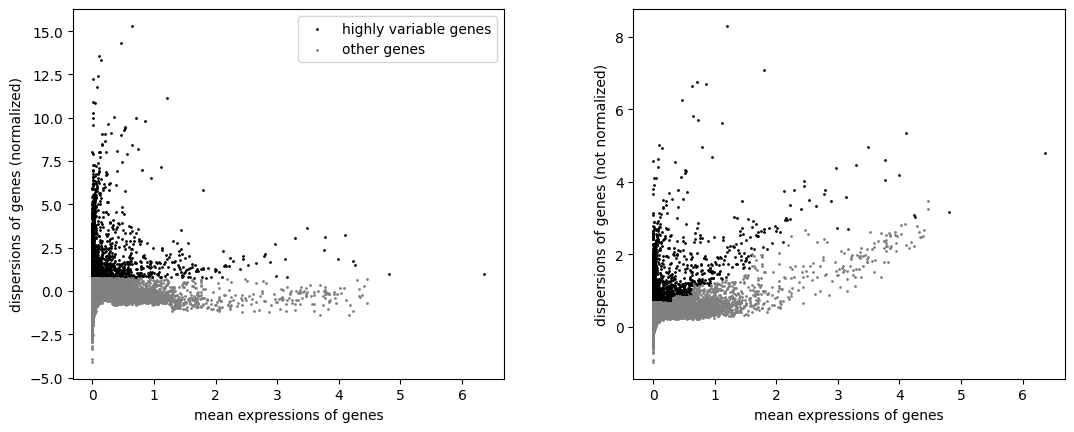

In [17]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [18]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


# Scanpy embeddings

In [19]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

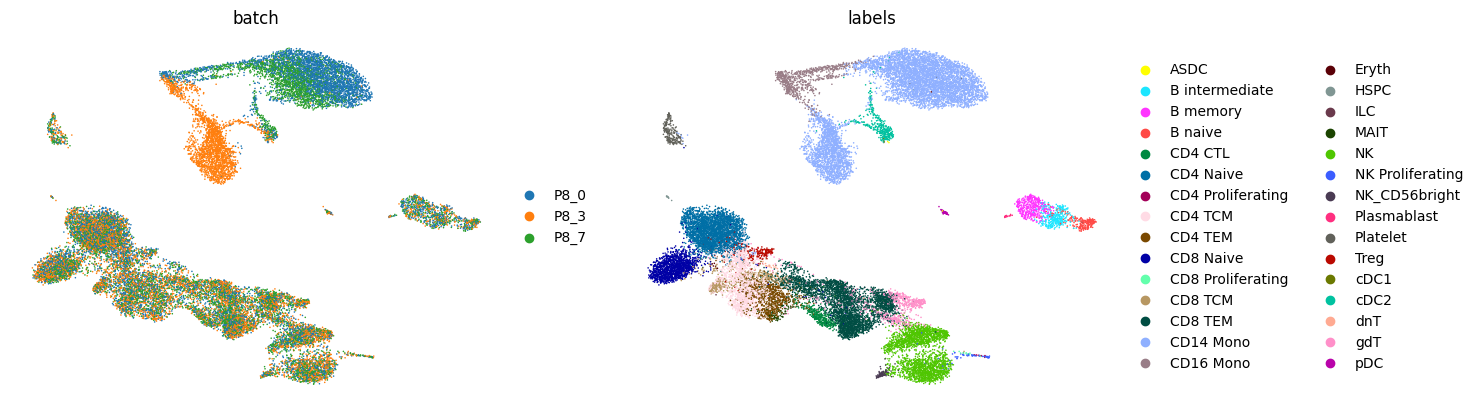

In [20]:
sc.pl.umap(adata, color=['batch', 'labels'], frameon=False)

# Harmony Integration

In [21]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


In [22]:
# Batch correction with Harmony
sc.external.pp.harmony_integrate(adata, 'batch')

2024-05-20 15:32:01,893 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-20 15:32:07,195 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-20 15:32:07,280 - harmonypy - INFO - Iteration 1 of 10
2024-05-20 15:32:11,785 - harmonypy - INFO - Iteration 2 of 10
2024-05-20 15:32:16,299 - harmonypy - INFO - Iteration 3 of 10
2024-05-20 15:32:20,791 - harmonypy - INFO - Iteration 4 of 10
2024-05-20 15:32:25,320 - harmonypy - INFO - Iteration 5 of 10
2024-05-20 15:32:29,823 - harmonypy - INFO - Iteration 6 of 10
2024-05-20 15:32:34,335 - harmonypy - INFO - Iteration 7 of 10
2024-05-20 15:32:38,843 - harmonypy - INFO - Iteration 8 of 10
2024-05-20 15:32:43,363 - harmonypy - INFO - Iteration 9 of 10
2024-05-20 15:32:45,046 - harmonypy - INFO - Converged after 9 iterations


In [23]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

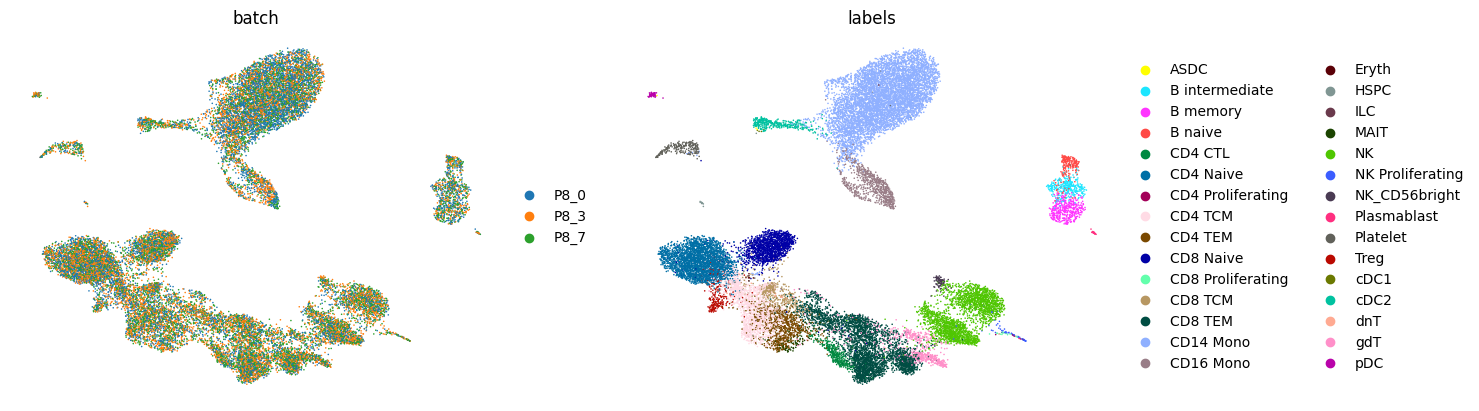

In [24]:
sc.pl.umap(adata, color=['batch', 'labels'], frameon=False)

/scratch/7289161.1.v100/ipykernel_1565130/1530453189.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
/scratch/7289161.1.v100/ipykernel_1565130/1530453189.py:3: SettingWithCopyWa

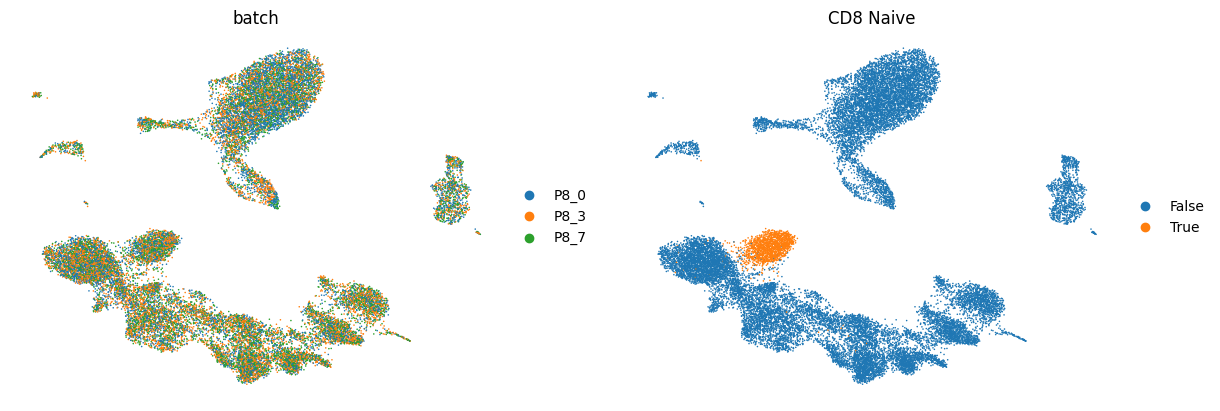

In [25]:
cell_type = 'CD8 Naive'
adata.obs[cell_type] = 'False'
adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
sc.pl.umap(adata, color=['batch', cell_type], frameon=False)

/scratch/7289161.1.v100/ipykernel_1565130/1332477425.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
/scratch/7289161.1.v100/ipykernel_1565130/1332477425.py:3: SettingWithCopyWa

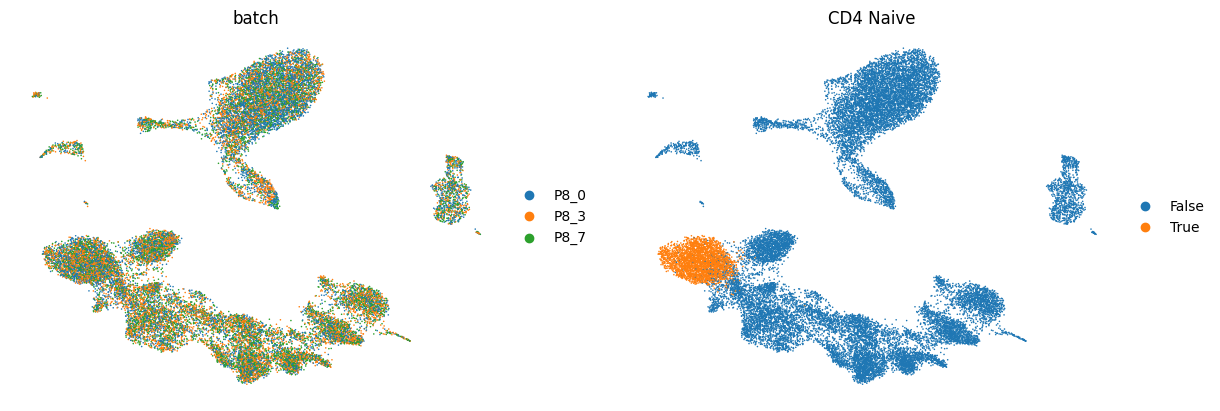

In [26]:
cell_type = 'CD4 Naive'
adata.obs[cell_type] = 'False'
adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
sc.pl.umap(adata, color=['batch', cell_type], frameon=False)

/scratch/7289161.1.v100/ipykernel_1565130/256791126.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
/scratch/7289161.1.v100/ipykernel_1565130/256791126.py:3: SettingWithCopyWarn

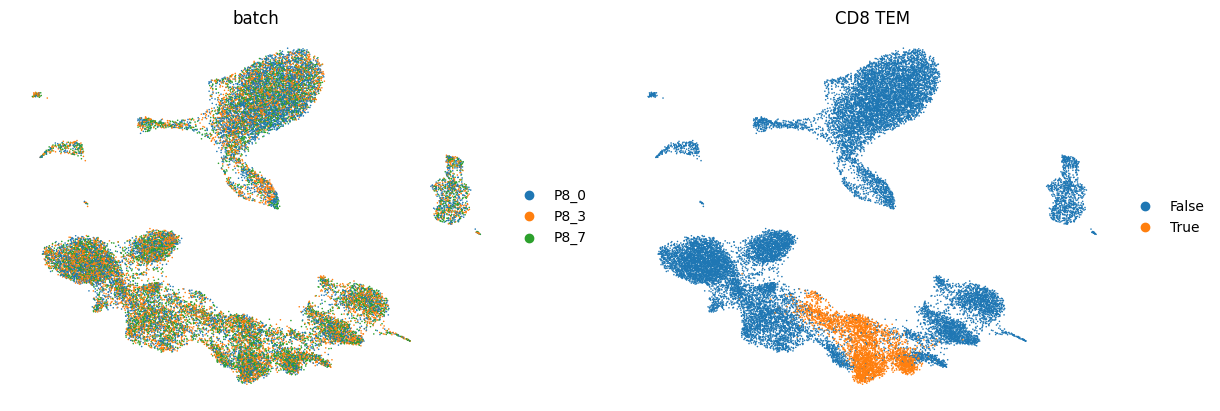

In [27]:
cell_type = 'CD8 TEM'
adata.obs[cell_type] = 'False'
adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
sc.pl.umap(adata, color=['batch', cell_type], frameon=False)

/scratch/7289161.1.v100/ipykernel_1565130/3477239001.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs['NK'][adata.obs['labels']=='NK']='True'
/scratch/7289161.1.v100/ipykernel_1565130/3477239001.py:2: SettingWithCopyWarning: 
A 

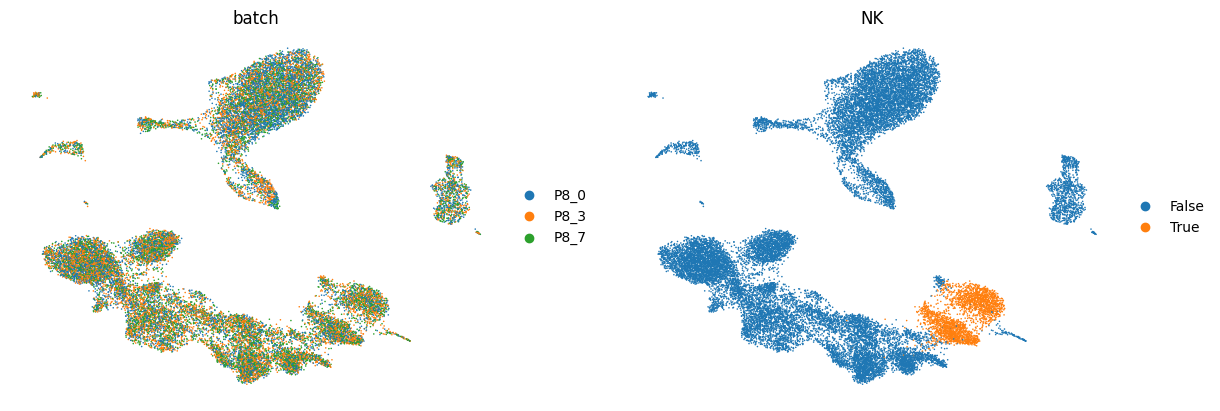

In [28]:
adata.obs['NK'] = 'False'
adata.obs['NK'][adata.obs['labels']=='NK']='True'
sc.pl.umap(adata, color=['batch', 'NK'], frameon=False)

In [ ]:
remove_1 = ['CD8 Naive', 'CD4 Naive', 'CD8 TEM', 'NK']
remove_2 = ['CD8 Naive', 'NK']

In [ ]:
remove_3 = ['CD4 Naive', 'NK']